<a href="https://colab.research.google.com/github/raphaelp-silva/deep_learning_com_pytorch_e_python/blob/main/Projeto_2_Classifica%C3%A7%C3%A3o_bin%C3%A1ria_breast_cancer_com_valida%C3%A7%C3%A3o_cruzada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 2: Classificação binária brest cancer com validação cruzada e dropout

## Etapa 1: Importação das bibliotecas

In [5]:
!pip install skorch

In [6]:
import pandas as pd
import numpy as np
import torch.nn as nn
import torch
import seaborn as sns
from sklearn.model_selection import cross_val_score
from skorch import NeuralNetBinaryClassifier

## Etapa 2: Base de dados

In [7]:
np.random.seed(123)
torch.manual_seed(123)

In [8]:
previsores = pd.read_csv('/content/entradas_breast.csv')
classe = pd.read_csv('/content/saidas_breast.csv')

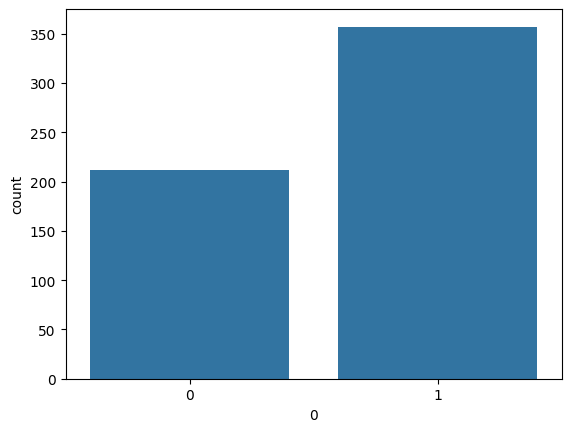

In [9]:
sns.countplot(x=classe['0']);

In [10]:
previsores = np.array(previsores, dtype = 'float32')
classe = np.array(classe, dtype = 'float32').squeeze(1) #utilizando o squeeze para retirar uma dimensão da tabela para em breve passar para o pytorch

In [11]:
classe.shape

(569,)

In [12]:
type(previsores)

numpy.ndarray

In [13]:
type(classe)

numpy.ndarray

## Etapa 3: Classe para estrutura da rede neural

** ATUALIZAÇÃO DEZ/2021 **: na versão atual do Skorch, os resultados da rede neural devem ser retornados sem ativação, ou seja, sem a camada sigmoide no final. Com isto, a função de custo deve ser `BCEWithLogitsLoss`.

In [14]:
#criando uma rede neural utilizando uma classe (skorch):

class classificador_torch(nn.Module):
  def __init__(self):
    super().__init__()

    # 30 -> 16 -> 16 -> 1
    #criando as camadas e funcoes de ativação dentro do metodo construtor da classe:
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)

#criando a conexão entre as camadas:
  def forward(self, x):
    x = self.dense0(x) #passando os atributos de entrada (x) para a primeira camada densa
    x = self.activation0(x) #passando os atributos para a funcao de ativacao
    x = self.dense1(x) #passando os atributos de entrada (x) para a primeira camada densa
    x = self.activation1(x) #passando os atributos para a funcao de ativacao
    x = self.dense2(x) #passando os atributos de entrada (x) para a primeira camada densa
    return x

## Etapa 4: Skorch

In [15]:
# criando um classificador compativel com o sklearn:

classificador_sklearn = NeuralNetBinaryClassifier( module = classificador_torch, #classe criada anteriormente
                                                   criterion = torch.nn.BCEWithLogitsLoss, #metodo de calculo de acuracia
                                                   optimizer = torch.optim.Adam, #otimizador Adam
                                                   lr = 0.001, # taxa de aprendizagem
                                                   optimizer__weight_decay = 0.0001,
                                                   max_epochs = 100,
                                                   batch_size = 10,
                                                   train_split = False #necessario para indicar que a divisao dos atributos ficará a cargo da proxima etapa (que será a validacao cruzada)
                                                  )

## Etapa 5: Validação cruzada

In [16]:
resultados = cross_val_score(classificador_sklearn, previsores, classe, cv = 10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1   107325.7532  0.4924
      2    86254.6258  0.1834
      3    68469.1940  0.1223
      4    53957.7447  0.1184
      5    42087.0118  0.1515
      6    32326.2574  0.1160
      7    24257.5023  0.1282
      8    17518.0601  0.1189
      9    11790.4094  0.1378
     10     6781.5044  0.1647
     11     2218.8259  0.1418
     12      192.7403  0.1223
     13      166.0598  0.1064
     14      142.9297  0.1027
     15      125.7638  0.1039
     16      106.8154  0.1198
     17       91.0951  0.1019
     18       85.3485  0.1014
     19       76.0606  0.1130
     20       69.1709  0.0965
     21       65.7409  0.0989
     22       50.8667  0.0990
     23       50.5946  0.1077
     24       50.5729  0.1058
     25       50.1516  0.1229
     26       45.3712  0.1007
     27       45.7941  0.1194
     28       49.1864  0.1348
     29       42.5406  0.1035
     30       40.9289  0.1331
     31       41.6919  0.1171
     32   

In [17]:
resultados.shape

(10,)

In [18]:
resultados

array([0.84210526, 0.71929825, 0.80701754, 0.92982456, 0.87719298,
       0.89473684, 0.85964912, 0.80701754, 0.84210526, 0.78571429])

In [19]:
media = resultados.mean()
media

0.8364661654135338

In [20]:
desvio_padrao = resultados.std()
desvio_padrao

0.0569293432217521

## Etapa 6: Dropout

In [21]:
class classificador_torch_dropout(nn.Module):
  def __init__(self):
    super().__init__()

    # 30 -> 16 -> 16 -> 1
    #criando as camadas e funcoes de ativação dentro do metodo construtor da classe:
    self.dense0 = nn.Linear(30, 16)
    torch.nn.init.uniform_(self.dense0.weight)
    self.activation0 = nn.ReLU()
    self.dropout = nn.Dropout(0.2) # adicionando aqui a funcao de dropout para 'zerar' 20% dos neurônios da rede.
    self.dense1 = nn.Linear(16, 16)
    torch.nn.init.uniform_(self.dense1.weight)
    self.activation1 = nn.ReLU()
    self.dropout = nn.Dropout(0.2) # adicionando aqui a funcao de dropout para 'zerar' 20% dos neurônios da rede.
    self.dense2 = nn.Linear(16, 1)
    torch.nn.init.uniform_(self.dense2.weight)

#criando a conexão entre as camadas:
  def forward(self, x):
    x = self.dense0(x) #passando os atributos de entrada (x) para a primeira camada densa
    x = self.activation0(x) #passando os atributos para a funcao de ativacao
    x = self.dropout(x) #adicionando a função de dropout
    x = self.dense1(x) #passando os atributos de entrada (x) para a primeira camada densa
    x = self.activation1(x) #passando os atributos para a funcao de ativacao
    x = self.dropout(x) #adicionando a função de dropout
    x = self.dense2(x) #passando os atributos de entrada (x) para a primeira camada densa
    return x

In [22]:
classificador_sklearn_dropout = NeuralNetBinaryClassifier( module = classificador_torch_dropout, #classe criada anteriormente
                                                   criterion = torch.nn.BCEWithLogitsLoss, #metodo de calculo de acuracia
                                                   optimizer = torch.optim.Adam, #otimizador Adam
                                                   lr = 0.001, # taxa de aprendizagem
                                                   optimizer__weight_decay = 0.0001,
                                                   max_epochs = 100,
                                                   batch_size = 10,
                                                   train_split = False #necessario para indicar que a divisao dos atributos ficará a cargo da proxima etapa (que será a validacao cruzada)
                                                  )

In [23]:
resultados_dropout = cross_val_score(classificador_sklearn_dropout, previsores, classe, cv=10, scoring = 'accuracy')

  epoch    train_loss     dur
-------  ------------  ------
      1    76826.3907  0.1101
      2    60939.8398  0.0834
      3    48414.3243  0.0703
      4    36653.4907  0.0669
      5    28374.9965  0.0676
      6    21817.0953  0.0743
      7    16252.4787  0.0814
      8    11266.8542  0.1269
      9     7430.2926  0.1477
     10     4148.7757  0.1117
     11     2851.8518  0.1348
     12     2349.3622  0.1045
     13     2574.3610  0.1103
     14     2280.8971  0.0978
     15     1909.6448  0.1014
     16     1792.1109  0.1249
     17     1636.7896  0.1973
     18     1475.0404  0.1114
     19     1628.6917  0.1150
     20     1758.2284  0.0739
     21     1512.2894  0.0746
     22     1185.2863  0.0723
     23     1009.3946  0.0714
     24     1060.6701  0.0762
     25     1212.9751  0.0803
     26      966.5793  0.0741
     27      882.4840  0.0834
     28      844.1323  0.0998
     29      831.6531  0.1691
     30      682.6986  0.1168
     31      725.7148  0.1109
     32   

In [24]:
resultados_dropout

array([0.68421053, 0.56140351, 0.59649123, 0.66666667, 0.66666667,
       0.61403509, 0.43859649, 0.63157895, 0.45614035, 0.83928571])

In [25]:
resultados

array([0.84210526, 0.71929825, 0.80701754, 0.92982456, 0.87719298,
       0.89473684, 0.85964912, 0.80701754, 0.84210526, 0.78571429])

In [26]:
media_dropout = resultados_dropout.mean()
media_dropout

0.6155075187969924

In [31]:
media = resultados.mean()
media

0.8364661654135338

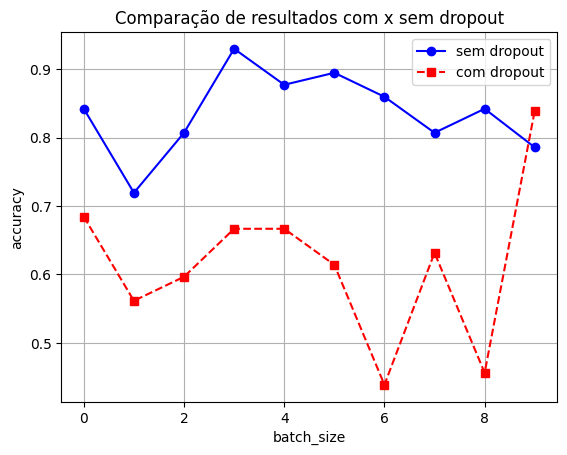

In [35]:
import matplotlib.pyplot as plt

resultados_sem_dropout = resultados
resultados_com_dropout = resultados_dropout

# Criando um eixo X baseado no tamanho dos arrays
x = np.arange(len(resultados_com_dropout))

# Plotando os dois conjuntos de dados
plt.plot(x, resultados_sem_dropout, marker='o', linestyle='-', color='b', label='sem dropout')
plt.plot(x, resultados_com_dropout, marker='s', linestyle='--', color='r', label='com dropout')
plt.xlabel('batch_size')
plt.ylabel('accuracy')
plt.title('Comparação de resultados com x sem dropout')
plt.legend()
plt.grid(True)
plt.show()
